In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("msambare/fer2013")
print("Path to dataset files:", path)

/Users/kevinshi/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/kevinshi/.cache/kagglehub/datasets/msambare/fer2013/versions/1


In [3]:
emotions = ['angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral']

# Each path is a directory full of .jpg files
dataset_dir_paths = {
    'train': {
        emotion: f'{path}/train/{emotion}' for emotion in emotions
    },
    'test': {
        emotion: f'{path}/test/{emotion}' for emotion in emotions
    }
}

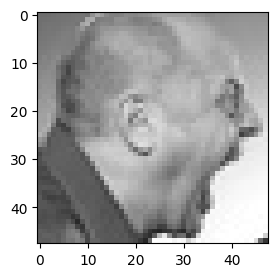

In [7]:
import cv2
import matplotlib.pyplot as plt
import os
import random

img_dir = dataset_dir_paths['train']['angry']
img_path = os.path.join(img_dir, random.choice(os.listdir(img_dir)))
# img_path = os.path.join(img_dir, 'Training_78260987.jpg')

img = cv2.imread(img_path)
plt.figure(figsize=(3, 3))
plt.imshow(img)
plt.show()

In [151]:
# STEP 1: Import the necessary modules.
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision

# STEP 2: Create an FaceLandmarker object.
base_options = python.BaseOptions(model_asset_path='face_landmarker_v2.task')
options = vision.FaceLandmarkerOptions(base_options=base_options,
                                       output_face_blendshapes=True,
                                       output_facial_transformation_matrixes=True,
                                       num_faces=1)
detector = vision.FaceLandmarker.create_from_options(options)

# STEP 3: Load the input image.
# image = mp.Image.create_from_file(img_path)
image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)

# STEP 4: Detect face landmarks from the input image.
detection_result = detector.detect(image)

# STEP 5: Process the detection result.
result = {
    blendshape.category_name: blendshape.score
    for blendshape in detection_result.face_blendshapes[0]
}
len(result)

I0000 00:00:1750713349.015002  792060 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 88), renderer: Apple M1
W0000 00:00:1750713349.015439  792060 face_landmarker_graph.cc:174] Sets FaceBlendshapesGraph acceleration to xnnpack by default.
W0000 00:00:1750713349.022630  876394 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1750713349.036349  876398 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


52

In [ ]:
features = ['_neutral', 'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft',
    'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight', 'eyeBlinkLeft',
    'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight', 'eyeLookInLeft', 'eyeLookInRight',
    'eyeLookOutLeft', 'eyeLookOutRight', 'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft',
    'eyeSquintRight', 'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft',
    'jawOpen', 'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight',
    'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft', 'mouthLowerDownLeft',
    'mouthLowerDownRight', 'mouthPressLeft', 'mouthPressRight', 'mouthPucker', 'mouthRight',
    'mouthRollLower', 'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper', 'mouthSmileLeft',
    'mouthSmileRight', 'mouthStretchLeft', 'mouthStretchRight', 'mouthUpperUpLeft', 
    'mouthUpperUpRight', 'noseSneerLeft', 'noseSneerRight']

In [167]:
import pandas as pd
from tqdm import tqdm
import glob

data_rows = []
for split in ['train', 'test']:
    for emotion in emotions:
        img_dir = dataset_dir_paths[split][emotion]
        img_files = glob.glob(os.path.join(img_dir, '*.jpg'))

        print(f"Processing {split}/{emotion}: {len(img_files)} images")

        for img_path in tqdm(img_files, desc=f"{split}/{emotion}"):
            try:
                # Extract image_id (filename without extension)
                image_id = os.path.splitext(os.path.basename(img_path))[0]

                # Load and process image
                image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                if image is None:
                    print(f"Warning: Could not load image {image_id}")
                    continue
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
                mp_image = mp.Image(image_format=mp.ImageFormat.SRGB, data=image)

                # Detect face landmarks
                detection_result = detector.detect(mp_image)

                # Check if face was detected
                if not detection_result.face_blendshapes or len(detection_result.face_blendshapes) == 0:
                    # print(f"Warning: No face detected in {image_id}")
                    continue

                # Extract blendshape scores
                blendshapes = {
                    blendshape.category_name: blendshape.score
                    for blendshape in detection_result.face_blendshapes[0]
                }
                assert len(blendshapes) == len(features)

                # Create row with image_id, label, split, and all features
                row = {
                    'image_id': image_id,
                    'label': emotion,
                    'split': split
                }

                # Add all blendshape features
                for feature_name in features:
                    row[feature_name] = blendshapes.get(feature_name, 0.0)

                data_rows.append(row)

            except Exception as e:
                print(f"Error processing {img_path}: {str(e)}")
                continue

print(f"Successfully processed {len(data_rows)} images")

# Create DataFrame and save to CSV
df = pd.DataFrame(data_rows)
csv_filename = 'fer2013_face_landmarks.csv'
df.to_csv(csv_filename, index=False)

print(f"Dataset saved to {csv_filename}")
print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nLabel distribution:")
print(df['label'].value_counts())
print("\nSplit distribution:")
print(df['split'].value_counts())


Processing train/angry: 3995 images


train/angry: 100%|██████████| 3995/3995 [00:35<00:00, 113.02it/s]


Processing train/disgust: 436 images


train/disgust: 100%|██████████| 436/436 [00:03<00:00, 116.68it/s]


Processing train/fear: 4097 images


train/fear: 100%|██████████| 4097/4097 [00:36<00:00, 112.57it/s]


Processing train/happy: 7215 images


train/happy: 100%|██████████| 7215/7215 [01:07<00:00, 106.40it/s]


Processing train/sad: 4830 images


train/sad: 100%|██████████| 4830/4830 [00:43<00:00, 111.78it/s]


Processing train/surprise: 3171 images


train/surprise: 100%|██████████| 3171/3171 [00:29<00:00, 107.72it/s]


Processing train/neutral: 4965 images


train/neutral: 100%|██████████| 4965/4965 [00:47<00:00, 104.16it/s]


Processing test/angry: 958 images


test/angry: 100%|██████████| 958/958 [00:08<00:00, 112.04it/s]


Processing test/disgust: 111 images


test/disgust: 100%|██████████| 111/111 [00:00<00:00, 117.24it/s]


Processing test/fear: 1024 images


test/fear: 100%|██████████| 1024/1024 [00:09<00:00, 111.59it/s]


Processing test/happy: 1774 images


test/happy: 100%|██████████| 1774/1774 [00:16<00:00, 108.23it/s]


Processing test/sad: 1247 images


test/sad: 100%|██████████| 1247/1247 [00:10<00:00, 116.35it/s]


Processing test/surprise: 831 images


test/surprise: 100%|██████████| 831/831 [00:07<00:00, 109.79it/s]


Processing test/neutral: 1233 images


test/neutral: 100%|██████████| 1233/1233 [00:11<00:00, 106.94it/s]


Successfully processed 32014 images
Dataset saved to fer2013_face_landmarks.csv
Dataset shape: (32014, 55)
Columns: ['image_id', 'label', 'split', '_neutral', 'browDownLeft', 'browDownRight', 'browInnerUp', 'browOuterUpLeft', 'browOuterUpRight', 'cheekPuff', 'cheekSquintLeft', 'cheekSquintRight', 'eyeBlinkLeft', 'eyeBlinkRight', 'eyeLookDownLeft', 'eyeLookDownRight', 'eyeLookInLeft', 'eyeLookInRight', 'eyeLookOutLeft', 'eyeLookOutRight', 'eyeLookUpLeft', 'eyeLookUpRight', 'eyeSquintLeft', 'eyeSquintRight', 'eyeWideLeft', 'eyeWideRight', 'jawForward', 'jawLeft', 'jawOpen', 'jawRight', 'mouthClose', 'mouthDimpleLeft', 'mouthDimpleRight', 'mouthFrownLeft', 'mouthFrownRight', 'mouthFunnel', 'mouthLeft', 'mouthLowerDownLeft', 'mouthLowerDownRight', 'mouthPressLeft', 'mouthPressRight', 'mouthPucker', 'mouthRight', 'mouthRollLower', 'mouthRollUpper', 'mouthShrugLower', 'mouthShrugUpper', 'mouthSmileLeft', 'mouthSmileRight', 'mouthStretchLeft', 'mouthStretchRight', 'mouthUpperUpLeft', 'mouthUp